In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


In [3]:
df = pd.read_csv("../data/processed/customer_rfm_with_target.csv")
df.head()

,CustomerId,Recency,Frequency,Monetary,Frequency_log,Monetary_log,cluster,is_high_risk
0,CustomerId_1,84,1,10000,0.693147,9.210440,0,1
1,CustomerId_10,84,1,10000,0.693147,9.210440,0,1
2,CustomerId_1001,90,5,30400,1.791759,10.322231,0,1
3,CustomerId_1002,26,11,4775,2.484907,8.471359,1,0
4,CustomerId_1003,12,6,32000,1.945910,10.373522,1,0


In [4]:
print("Shape:", df.shape)
df.info()
df["is_high_risk"].value_counts(normalize=True)

Shape: (3742, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerId     3742 non-null   object 
 1   Recency        3742 non-null   int64  
 2   Frequency      3742 non-null   int64  
 3   Monetary       3742 non-null   int64  
 4   Frequency_log  3742 non-null   float64
 5   Monetary_log   3742 non-null   float64
 6   cluster        3742 non-null   int64  
 7   is_high_risk   3742 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 234.0+ KB


is_high_risk
0    0.67504
1    0.32496
Name: proportion, dtype: float64

In [5]:
# prepare features and target
feature_cols = [
    "Recency",
    "Frequency",
    "Monetary",
    "Frequency_log",
    "Monetary_log",
]

X = df[feature_cols]
y = df["is_high_risk"]


In [6]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# scale only continuous features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: logistic regression

In [9]:
# Train Logistic Regression
log_reg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced",   # helps with imbalanced target
)

log_reg.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [10]:
# Evaluate logistic regression
log_preds = log_reg.predict(X_test_scaled)
log_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, log_preds))
print("Precision:", precision_score(y_test, log_preds))
print("Recall:", recall_score(y_test, log_preds))
print("F1:", f1_score(y_test, log_preds))
print("ROC-AUC:", roc_auc_score(y_test, log_probs))

print("\nClassification Report:\n")
print(classification_report(y_test, log_preds))

Logistic Regression Performance:
Accuracy: 0.9692923898531375
Precision: 0.9166666666666666
Recall: 0.9958847736625515
F1: 0.9546351084812623
ROC-AUC: 0.9980725125652662

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       506
           1       0.92      1.00      0.95       243

    accuracy                           0.97       749
   macro avg       0.96      0.98      0.97       749
weighted avg       0.97      0.97      0.97       749



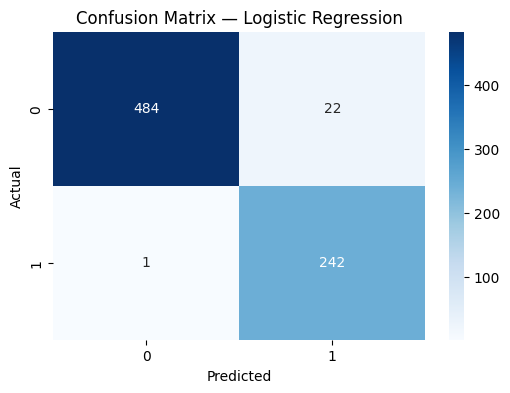

In [11]:
# confusion matrix
cm = confusion_matrix(y_test, log_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# MODEL 2: Random Forest

In [12]:
# train random forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight="balanced",
)

rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# evaluate random forest
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Precision:", precision_score(y_test, rf_preds))
print("Recall:", recall_score(y_test, rf_preds))
print("F1:", f1_score(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))

print("\nClassification Report:\n")
print(classification_report(y_test, rf_preds))


Random Forest Performance:
Accuracy: 0.9906542056074766
Precision: 0.9758064516129032
Recall: 0.9958847736625515
F1: 0.9857433808553971
ROC-AUC: 0.999878007124384

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       506
           1       0.98      1.00      0.99       243

    accuracy                           0.99       749
   macro avg       0.99      0.99      0.99       749
weighted avg       0.99      0.99      0.99       749



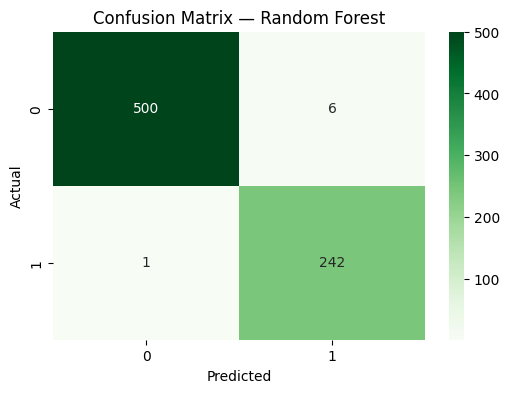

In [14]:
# confusion matrix
cm = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


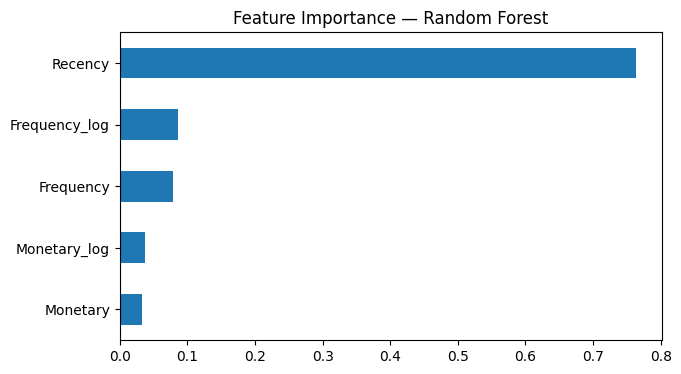

In [15]:
# plot feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols)

plt.figure(figsize=(7,4))
importances.sort_values().plot(kind="barh")
plt.title("Feature Importance — Random Forest")
plt.show()


In [16]:
# save the model
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

joblib.dump(log_reg, f"{models_dir}/logistic_regression.joblib")
joblib.dump(rf, f"{models_dir}/random_forest.joblib")
joblib.dump(scaler, f"{models_dir}/scaler.joblib")

"Models saved."


'Models saved.'

# Explainability

In [17]:
!pip install shap
import shap

# Initialize JS visualization
shap.initjs()


In [18]:
# crate shap explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)


In [19]:
print("shap_values shape:", np.array(shap_values).shape)

shap_values shape: (2993, 5, 2)


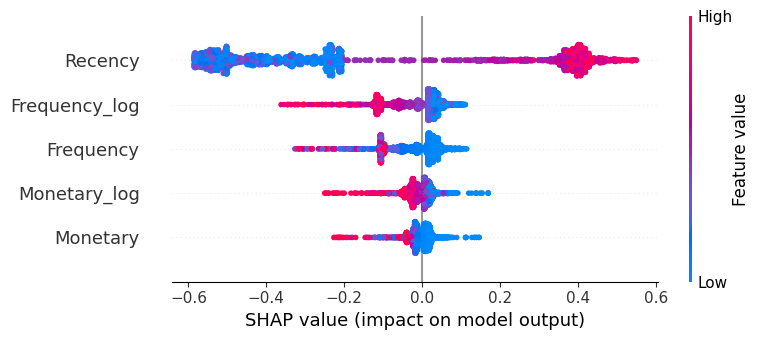

In [20]:
# Global Explainability — SHAP Summary Plot 
# shap_values is (n_samples, n_features, n_classes)
# --> We choose class 1 (high risk)
shap_to_plot = shap_values[:, :, 1]

# Summary plot for high-risk class
shap.summary_plot(shap_to_plot, X_train, feature_names=feature_cols)

In [21]:
# pick one sample
sample = X_train.iloc[[0]]

# SHAP values for this sample -> shape (1, 5, 2)
sample_shap = explainer.shap_values(sample)
print("sample_shap shape:", sample_shap.shape)

# take class 1 (high-risk) SHAP values, squeeze to 1D (5,)
sample_values = sample_shap[0, :, 1]

sample, sample_values


sample_shap shape: (1, 5, 2)


(      Recency  Frequency  Monetary  Frequency_log  Monetary_log
 2347       89          1    700000       0.693147     13.458837,
 array([ 0.40632152,  0.09478796, -0.078031  ,  0.09484743, -0.07744318]))

In [22]:
# Get expected value for class 1 (high-risk)
expected_val = explainer.expected_value
if isinstance(expected_val, (list, tuple, np.ndarray)):
    expected_val_1 = expected_val[1]
else:
    expected_val_1 = expected_val

shap.force_plot(
    expected_val_1,
    sample_values,
    sample,
    feature_names=feature_cols
)